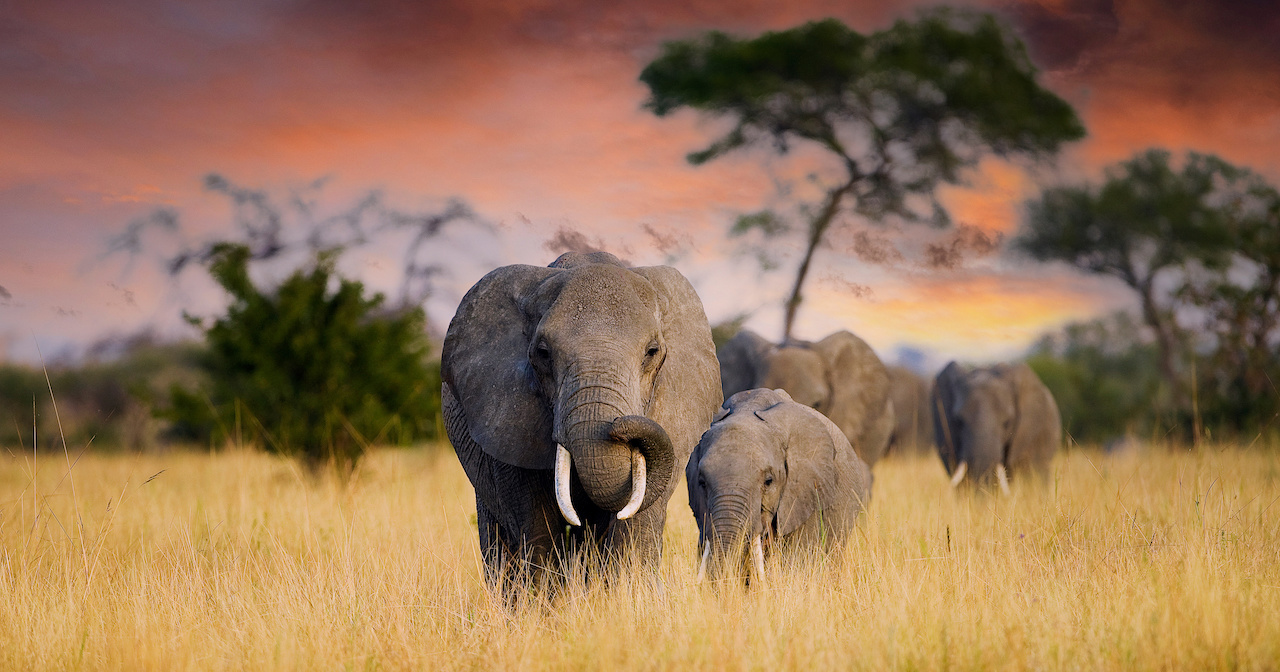
Photo by <a href="https://stock.adobe.com/contributor/19000/mat-hayward?load_type=author&prev_url=detail" >Mat Hayward</a> on Adobe Stock

# Phase 4 Project: *The Met Museum Ivory Art Classification Model*

### By Ryan Posternak and Harrison Carter

Flatiron School, Full-Time Live NYC<br>
Project Presentation Date: August 6th, 2022<br>
Instructor: Joseph Mata

## Goal: Identify whether a piece of artwork among the Met museum's art collection is made of ivory or not

<br>

Limitations:
- Will not catch objects where ivory is only a minor design, or where the ivory may be obscured with paint or other concealer
- Will have false positives for bone/ivory from animals other than elephants, e.g. walrus or mammoth

# Overview and Business Understanding

<br>

Elephants are crucial not only as biological and cultural icons, but as keystone species in their ecosystems. Consisting of  three main species (African Forest, African Savanna, Asian) each serve myriad purposes in their respective environments including habitat creation, seed dispersal, forest pathway creation, brush cover management, among many others. In 1930, an estimated 10 million wild elephants existed on the African continent. After years of poaching and other human intervention that number declined to approximately 496,000 by 2007. In the following seven years their population was further reduced by 30% to 352,271 according to [The Great Elephant Census](https://en.wikipedia.org/wiki/Great_Elephant_Census), the largest wildlife survey in history.

Each year, poachers kill an estimated 20,000 ([WWF](https://www.worldwildlife.org/species/elephant)) wild elephants for illegal trade, mostly dealing in ivory. With so few of these animals remaining, this leaves precious few years for them on the planet. In 2016, many countries including the United States, United Kingdom, Singapore and others implemented a near complete ban on importing and sales of ivory and ivory products. In a massive step, China followed suit the following year, disallowing legal sale of ivory within the country, a move that is "widely regarded as the single biggest step to end the slaughter of elephants"([EIA](https://eia-international.org/wildlife/protecting-elephants/saving-elephants-from-the-ivory-trade/), 2022), "eliminating an estimated 70 percent of the global ivory market." ([Smithsonian Magazine](https://www.smithsonianmag.com/science-nature/faking-elephant-ivory-180963226/)). Unfortunately this is not enough, as consumer imports of ivory from abroad are still allowed. In places like Vietnam and Thailand, the sale of ivory is illegal in name only, with little to no enforcement and street vendors and jewelry shops alike populating their shelves brazenly. This leads to a wholly unregulated market, with over 56 tons of it entering Vietnam's black market and another 20 tons stopped in transit between 2009 and 2018 ([Sustainability Times](https://www.sustainability-times.com/environmental-protection/from-africa-to-vietnam-the-flow-of-ivory-is-relentess/)).



To combat this, wildlife conservationists are constantly urging countries worldwide to enact stricter legislation, but the emergence of online shopping and peer-to-peer marketplaces presents a major roadblock. Although major websites are able to filter out listings by keyword, there is no way to tell if postings under alternate names or pseudonymns contain ivory objects. Here we have created proof of concept for a machine learning model that takes in image data with regards to a three dimensional piece of art and separates those that may contain ivory from those that don't. This can be used to identify listings potentially containing ivory contraband and flag them for further investigation.

<br>

# Data Understanding

<br>

<br>

# Sourcing the Data

### Import libraries, packages and modules

In [116]:
import numpy as np
import pandas as pd
import requests
import time
import random
from PIL import Image
import imagesize
from pathlib import Path
from io import BytesIO
import os
import shutil
import joblib

from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')
%matplotlib inline

### Connect to Met API

In [117]:
# API URL to obtain IDs of ivory objects
ivory_url = 'https://collectionapi.metmuseum.org/public/collection/v1/search?medium=Ivory&q=*'

# API URL to obtain IDs of (expected to be) non-ivory ceramic objects
non_ivory_url = 'https://collectionapi.metmuseum.org/public/collection/v1/search?medium=Ceramics&hasImages=true&q=*'

# Ivory objects request
ivory_r = requests.get(ivory_url)

# Non-ivory objects request
non_ivory_r = requests.get(non_ivory_url)

ivory_r.status_code, non_ivory_r.status_code

(200, 200)

In [3]:
# Retrieve objectIds
ivory_objectIDs = ivory_r.json()['objectIDs']
non_ivory_objectIDs = non_ivory_r.json()['objectIDs']


print(f"Number of ivory objects: {len(ivory_objectIDs)}")
print(f"Number of ceramic objects: {len(non_ivory_objectIDs)}")

Number of ivory objects: 5975
Number of ceramic objects: 25603


In [4]:
# Let's view the full data on one museum art piece (the first ivory object in our list)
url = 'https://collectionapi.metmuseum.org/public/collection/v1/objects/'

requests.get(url + str(ivory_objectIDs[0])).json()

{'objectID': 248694,
 'isHighlight': False,
 'accessionNumber': '12.229.23b',
 'accessionYear': '1912',
 'isPublicDomain': True,
 'primaryImage': 'https://images.metmuseum.org/CRDImages/gr/original/sf1222923b.jpg',
 'primaryImageSmall': 'https://images.metmuseum.org/CRDImages/gr/web-large/sf1222923b.jpg',
 'additionalImages': [],
 'constituents': None,
 'department': 'Greek and Roman Art',
 'objectName': 'Relief of a duck',
 'title': 'Relief of a duck',
 'culture': 'Roman',
 'period': 'Early Imperial',
 'dynasty': '',
 'reign': '',
 'portfolio': '',
 'artistRole': '',
 'artistPrefix': '',
 'artistDisplayName': '',
 'artistDisplayBio': '',
 'artistSuffix': '',
 'artistAlphaSort': '',
 'artistNationality': '',
 'artistBeginDate': '',
 'artistEndDate': '',
 'artistGender': '',
 'artistWikidata_URL': '',
 'artistULAN_URL': '',
 'objectDate': '1st century A.D.',
 'objectBeginDate': 1,
 'objectEndDate': 99,
 'medium': 'Bone',
 'dimensions': '1 13/16 × 5/8 × 4 3/16 in. (4.7 × 1.6 × 10.6 cm)',

### Create container lists with selected attributes

In [5]:
# Initialize lists
ivory_primaryImageSmall_urls = []
ivory_titles = []
ivory_objectNames = []
ivory_mediums = []
ivory_classifications = []
ivory_departments = []
ivory_cultures = []
ivory_periods = []
ivory_objectDates = []

# Compile containers
attribute_containers = [ivory_primaryImageSmall_urls, ivory_titles, ivory_objectNames, ivory_mediums, 
                        ivory_classifications, ivory_departments, ivory_cultures, ivory_periods, ivory_objectDates]

# Compile key names of attributes
attributes = ['primaryImageSmall', 'title', 'objectName', 'medium', 
              'classification', 'department', 'culture', 'period', 'objectDate']

# Execute API requests
objects_url = 'https://collectionapi.metmuseum.org/public/collection/v1/objects/'

# Prevent running duplicate API requests
if os.path.isfile('data/ivory_df.csv') == False:
    for objectID in ivory_objectIDs:
        r = requests.get(objects_url + str(objectID))
        for attribute_container, attribute in zip(attribute_containers, attributes):
            try:
                attribute_container.append(r.json()[attribute])
            except:
                attribute_container.append(np.nan)  # Some keys are missing on select objects
        time.sleep(1/80)  # Throttle API request rate to conform with API documentation

### Create dataframe of ivory art pieces

In [6]:
# Only run if ivory_df has not been saved to data/ folder yet
try:
    ivory_df = pd.DataFrame(ivory_objectIDs, columns=['Object_ID'])

    ivory_df['Image_URL'] = ivory_primaryImageSmall_urls
    ivory_df['Title'] = ivory_titles
    ivory_df['Object_Name'] = ivory_objectNames
    ivory_df['Medium'] = ivory_mediums
    ivory_df['Classification'] = ivory_classifications
    ivory_df['Department'] = ivory_departments
    ivory_df['Culture'] = ivory_cultures
    ivory_df['Period'] = ivory_periods
    ivory_df['Object_Date'] = ivory_objectDates

    # Ivory art pieces will have class labels of 1
    ivory_df['Target'] = 1
    # Replace blank (missing) values with NaN
    ivory_df.replace(to_replace='', value=np.nan, inplace=True)

    print(ivory_df.shape)
    display(ivory_df.head())

except:
    ivory_df = pd.read_csv('data/ivory_df.csv', index_col=0)
    
    print(ivory_df.shape)
    display(ivory_df.head())

(5975, 11)


Object_ID                                          Image_URL  \
0     248694  https://images.metmuseum.org/CRDImages/gr/web-...   
1     248695  https://images.metmuseum.org/CRDImages/gr/web-...   
2     257575  https://images.metmuseum.org/CRDImages/gr/web-...   
3      25138                                                NaN   
4      25137                                                NaN   

               Title        Object_Name                             Medium  \
0   Relief of a duck   Relief of a duck                               Bone   
1  Relief of a child  Relief of a child                               Bone   
2         Eye inlays         Eye inlays                        Bone, ivory   
3   Dirk with Sheath   Dirk with sheath        Steel, ivory, leather, gold   
4          Cinquedea          Cinquedea  Steel, brass, ivory, gold, latten   

              Classification           Department  Culture          Period  \
0  Miscellaneous-Bone, Ivory  Greek and Roman Art    Roman  Early Imperial   
1  Miscellaneous-Bone, Ivory  Greek and Roman Art      NaN             NaN   
2  Miscellaneous-Bone, Ivory  Greek and Roman Art      NaN             NaN   
3                    Daggers       Arms and Armor   French             NaN   
4                    Daggers       Arms and Armor  Italian             NaN   

        Object_Date  Target  
0  1st century A.D.       1  
1               NaN       1  
2               NaN       1  
3      16th century       1  
4           1525–50       1

### Save dataframe to data folder

In [7]:
# Only save the dataframe if it doesn't already exist yet
if os.path.isfile('data/ivory_df.csv') == False:
    ivory_df.to_csv('data/ivory_df.csv')
else:
    pass

In [8]:
# How many of the ivory objects have valid (small) image URLs?
num_ivory_objects_with_image = ivory_df.shape[0] - ivory_df.Image_URL.isna().sum()
num_ivory_objects_with_image

4617

In [9]:
# Choose 5,975 random objectIds from the non_ivory_objectIDs list
np.random.seed(10)
selected_non_ivory_objectIDs = np.random.choice(non_ivory_objectIDs, size=5975, replace=False)
print(f"{len(selected_non_ivory_objectIDs)} object IDs selected from non_ivory_objectIDs list")

5975 object IDs selected from non_ivory_objectIDs list


### Repeat steps above to create dataframe of non-ivory art pieces

In [10]:
non_ivory_primaryImageSmall_urls = []
non_ivory_titles = []
non_ivory_objectNames = []
non_ivory_mediums = []
non_ivory_classifications = []
non_ivory_departments = []
non_ivory_cultures = []
non_ivory_periods = []
non_ivory_objectDates = []

attribute_containers = [non_ivory_primaryImageSmall_urls, non_ivory_titles, non_ivory_objectNames, 
                        non_ivory_mediums, non_ivory_classifications, non_ivory_departments, non_ivory_cultures, 
                        non_ivory_periods, non_ivory_objectDates]

attributes = ['primaryImageSmall', 'title', 'objectName', 'medium', 
              'classification', 'department', 'culture', 'period', 'objectDate']

if os.path.isfile('data/final_df.csv') == False:
    for objectID in selected_non_ivory_objectIDs:
        r = requests.get(objects_url + str(objectID))
        for attribute_container, attribute in zip(attribute_containers, attributes):
            try:
                attribute_container.append(r.json()[attribute])
            except:
                attribute_container.append(np.nan)
        time.sleep(1/80)

In [11]:
# Only run if non_ivory_df has not been saved to data/ folder yet
try:
    non_ivory_df = pd.DataFrame(selected_non_ivory_objectIDs, columns=['Object_ID'])

    non_ivory_df['Image_URL'] = non_ivory_primaryImageSmall_urls
    non_ivory_df['Title'] = non_ivory_titles
    non_ivory_df['Object_Name'] = non_ivory_objectNames
    non_ivory_df['Medium'] = non_ivory_mediums
    non_ivory_df['Classification'] = non_ivory_classifications
    non_ivory_df['Department'] = non_ivory_departments
    non_ivory_df['Culture'] = non_ivory_cultures
    non_ivory_df['Period'] = non_ivory_periods
    non_ivory_df['Object_Date'] = non_ivory_objectDates

    # Non-ivory art pieces will have class labels of 0
    non_ivory_df['Target'] = 0
    # Replace blank (missing) values with NaN
    non_ivory_df.replace(to_replace='', value=np.nan, inplace=True)
    # Remove objects without valid (small) image URLs
    non_ivory_df.dropna(subset=['Image_URL'], inplace=True)
    
    print(non_ivory_df.shape)
    display(non_ivory_df.head())
    
except:
    non_ivory_df = pd.read_csv('data/non_ivory_df.csv', index_col=0)
    print(non_ivory_df.shape)
    display(non_ivory_df.head())

(5320, 11)


Object_ID                                          Image_URL  \
0     186685  https://images.metmuseum.org/CRDImages/es/web-...   
1     194344  https://images.metmuseum.org/CRDImages/es/web-...   
2      47555  https://images.metmuseum.org/CRDImages/as/web-...   
4      48435  https://images.metmuseum.org/CRDImages/as/web-...   
6     695250  https://images.metmuseum.org/CRDImages/md/web-...   

                                            Title       Object_Name  \
0  Bowl with Saint Francis receiving the stigmata              Bowl   
1                                           Plate             Plate   
2                                           Plate             Plate   
4                                Model of a stove  Model of a stove   
6                                        Fragment          Fragment   

                                        Medium    Classification  \
0  Maiolica (tin-glazed earthenware), lustered  Ceramics-Pottery   
1             Faience (tin-glazed earthenware)  Ceramics-Pottery   
2                                    Porcelain          Ceramics   
4                 Earthenware with green glaze      Tomb Pottery   
6                               Glass, ceramic     Glass-Vessels   

                               Department                     Culture  \
0  European Sculpture and Decorative Arts                         NaN   
1  European Sculpture and Decorative Arts                         NaN   
2                               Asian Art                       China   
4                               Asian Art                       China   
6                            Medieval Art  European or Middle Eastern   

                            Period        Object_Date  Target  
0                              NaN       16th century       0  
1                              NaN          1730–1800       0  
2         Ming dynasty (1368–1644)                NaN       0  
4  Han dynasty (206 B.C.–A.D. 220)    1st–2nd century       0  
6                              NaN  ca. 1150–ca. 1250       0

### Save dataframe to data folder

In [12]:
# Only save the dataframe if it doesn't already exist yet
if os.path.isfile('data/non_ivory_df.csv') == False:
    non_ivory_df.to_csv('data/non_ivory_df.csv')
else:
    pass

### Concatenate dataframes

In [13]:
merged_df = pd.concat([ivory_df, non_ivory_df], ignore_index=True)
print(merged_df.shape)
merged_df.head()

(11295, 11)


Object_ID                                          Image_URL  \
0     248694  https://images.metmuseum.org/CRDImages/gr/web-...   
1     248695  https://images.metmuseum.org/CRDImages/gr/web-...   
2     257575  https://images.metmuseum.org/CRDImages/gr/web-...   
3      25138                                                NaN   
4      25137                                                NaN   

               Title        Object_Name                             Medium  \
0   Relief of a duck   Relief of a duck                               Bone   
1  Relief of a child  Relief of a child                               Bone   
2         Eye inlays         Eye inlays                        Bone, ivory   
3   Dirk with Sheath   Dirk with sheath        Steel, ivory, leather, gold   
4          Cinquedea          Cinquedea  Steel, brass, ivory, gold, latten   

              Classification           Department  Culture          Period  \
0  Miscellaneous-Bone, Ivory  Greek and Roman Art    Roman  Early Imperial   
1  Miscellaneous-Bone, Ivory  Greek and Roman Art      NaN             NaN   
2  Miscellaneous-Bone, Ivory  Greek and Roman Art      NaN             NaN   
3                    Daggers       Arms and Armor   French             NaN   
4                    Daggers       Arms and Armor  Italian             NaN   

        Object_Date  Target  
0  1st century A.D.       1  
1               NaN       1  
2               NaN       1  
3      16th century       1  
4           1525–50       1

<br>

# Data Preprocessing

### Drop duplicate object IDs, null image URLs, and duplicate image URLs

In [118]:
print('Before preprocessing:' + '\n')

# Search for duplicate Object_IDs
num_dup_IDs = merged_df.loc[merged_df.duplicated(subset='Object_ID', keep=False)].shape[0]
print(str(num_dup_IDs) + ' duplicate Object_IDs')

# Remove from dataframe (keep first occurrence)
dup_ID_indexes = merged_df.loc[merged_df.duplicated(subset='Object_ID', keep=False)].index
merged_df = merged_df.drop(dup_ID_indexes)

# Search for NaN Image_URLs
num_NaN_Image_URLs = merged_df.loc[merged_df['Image_URL'].isna()].shape[0]
print(str(num_NaN_Image_URLs) + ' null Image_URLs')

# Remove from dataframe
NaN_Image_URL_indexes = merged_df.loc[merged_df['Image_URL'].isna()].index
merged_df = merged_df.drop(NaN_Image_URL_indexes)

# Search for duplicate Image_URLs
num_dup_Image_URLs = merged_df.loc[merged_df.duplicated(subset='Image_URL')].shape[0]
print(str(num_dup_Image_URLs) + ' duplicate Image_URLs')

# Remove from dataframe (keep first occurrence)
dup_Image_URL_indexes = merged_df.loc[merged_df.duplicated(subset='Image_URL')].index
merged_df = merged_df.drop(dup_Image_URL_indexes)

print('-'*30)
print('After preprocessing:' + '\n')
print(str(merged_df.loc[merged_df.duplicated(subset='Object_ID', keep=False)].shape[0]) + ' duplicate Object_IDs')
print(str(merged_df.loc[merged_df['Image_URL'].isna()].shape[0]) + ' null Image_URLs')
print(str(merged_df.loc[merged_df.duplicated(subset='Image_URL')].shape[0]) + ' duplicate Image_URLs')

Before preprocessing:

0 duplicate Object_IDs
0 null Image_URLs
0 duplicate Image_URLs
------------------------------
After preprocessing:

0 duplicate Object_IDs
0 null Image_URLs
0 duplicate Image_URLs


### Drop art pieces where ivory is only a minor element of the design

In [119]:
# Let's preview the mediums of our ivory objects
merged_df.loc[merged_df.Target == 1].Medium.value_counts()[:30]

Ivory                                           1382
Watercolor on ivory                              562
Bone                                             140
Bone; incised and inlaid with paint              125
Bone; tinted, incised, and inlaid with paint      53
Elephant ivory                                    53
Bone; carved                                      32
Wood; carved, inlaid with ivory                   31
Ivory (walrus)                                    31
ivory                                             27
Walrus ivory                                      26
Steel, ivory                                      23
Bone; incised                                     23
Ivory with metal mounts                           20
Ivory or bone                                     19
Wood, ivory                                       17
Paper, ivory                                      17
Silver, ivory                                     16
Wood; inlaid with ivory                       

4230
Ivory


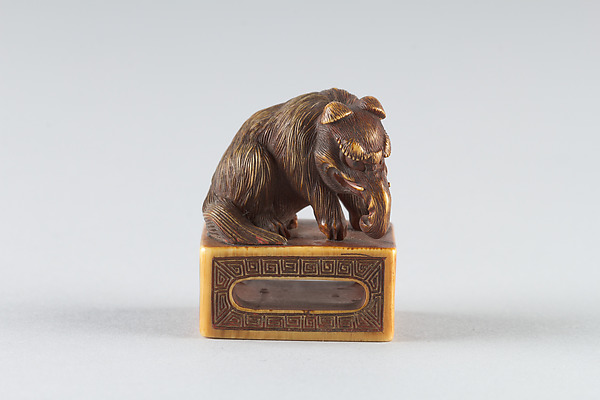

1658
Ivory


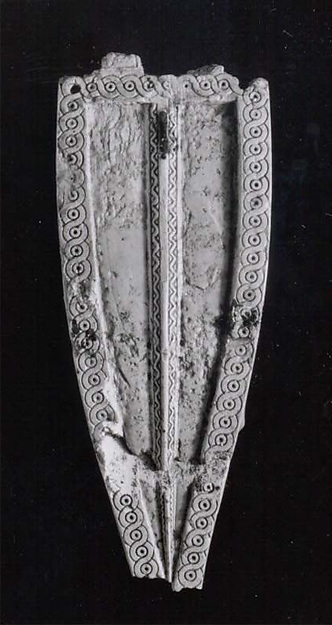

1853
Ivory


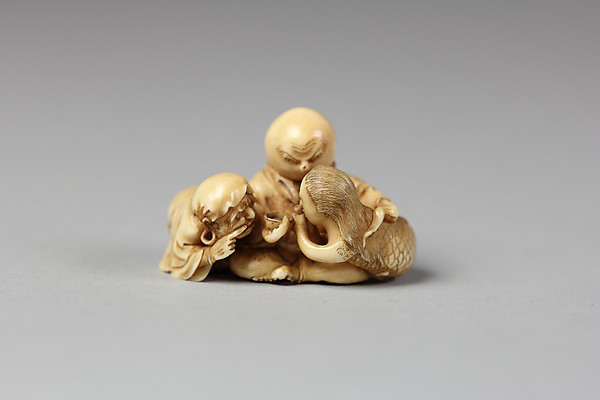

In [120]:
# These are the art mediums that appear most relevant to our search for ivory objects. The others might hardly 
# have any trace of bone/ivory for the model to pick up on. We'll also include other forms of ivory besides 
# elephant ivory, such as walrus ivory, due to the similarity in appearance.
ivory_indexes_to_keep = merged_df.loc[(merged_df.Medium == 'Ivory') | 
                                      (merged_df.Medium == 'Bone') | 
                                      (merged_df.Medium == 'Bone, ivory') | 
                                      (merged_df.Medium == 'Elephant ivory') | 
                                      (merged_df.Medium == 'Bone; carved') | 
                                      (merged_df.Medium == 'Ivory (walrus)') | 
                                      (merged_df.Medium == 'ivory') | 
                                      (merged_df.Medium == 'Walrus ivory') | 
                                      (merged_df.Medium == 'Bone; incised') | 
                                      (merged_df.Medium == 'Ivory with metal mounts') | 
                                      (merged_df.Medium == 'Ivory or bone') | 
                                      (merged_df.Medium == 'Ivory (elephant)')
                                     ].index

# Let's preview three items from above
np.random.seed(42)
for index in np.random.choice(ivory_indexes_to_keep, size=3, replace=False):
    test = requests.get(merged_df.loc[index].Image_URL)
    img_test = Image.open(BytesIO(test.content))
    print(index)
    print(merged_df.loc[index].Medium)
    display(img_test)

970
Wood; carved, inlaid with plain and carved ivory


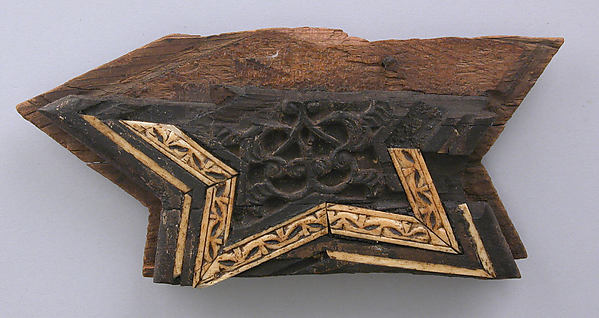

5948
Ivory, gold


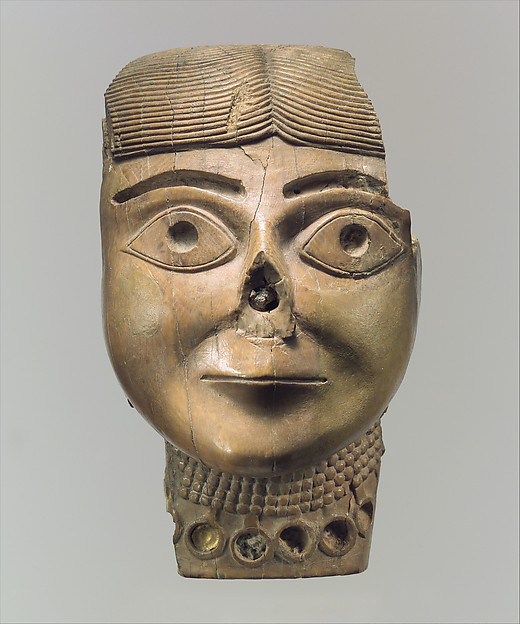

2649
Carved ivory; mounted over wood frame; brass mounts


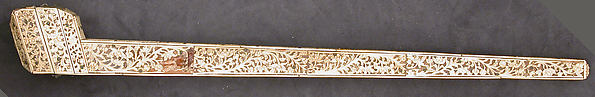

In [121]:
# Just to be sure, let's preview three items that don't fit the medium descriptions above, to see if they are 
# still recognizable as ivory or not
all_ivory_indexes = merged_df.loc[merged_df.Target == 1].index
ivory_indexes_to_drop = [index for index in all_ivory_indexes if index not in ivory_indexes_to_keep]

np.random.seed(42)
for index in np.random.choice(ivory_indexes_to_drop, size=3, replace=False):
    test = requests.get(merged_df.loc[index].Image_URL)
    img_test = Image.open(BytesIO(test.content))
    print(index)
    print(merged_df.loc[index].Medium)
    display(img_test)

**Remarks**:
- As suspected, the images not among the selected mediums appear to have little, if any, traces of ivory, although ivory may be some element of their composition. We'll go ahead and keep only the items among the selected mediums. Even though this will be costly in terms of lost data, these art pieces we're dropping would likely bring more noise than signal.

### Create new dataframes from refined selections of objects

In [122]:
new_ivory_df = merged_df.loc[ivory_indexes_to_keep]
print(new_ivory_df.shape)
new_ivory_df.head()

(1770, 11)


Object_ID                                          Image_URL  \
0      248694  https://images.metmuseum.org/CRDImages/gr/web-...   
1      248695  https://images.metmuseum.org/CRDImages/gr/web-...   
2      257575  https://images.metmuseum.org/CRDImages/gr/web-...   
16      31064  https://images.metmuseum.org/CRDImages/aa/web-...   
72      34077  https://images.metmuseum.org/CRDImages/aa/web-...   

                  Title          Object_Name       Medium  \
0      Relief of a duck     Relief of a duck         Bone   
1     Relief of a child    Relief of a child         Bone   
2            Eye inlays           Eye inlays  Bone, ivory   
16  Sword with Scabbard  Sword with scabbard        Ivory   
72     Hilt of a Dagger     Hilt of a dagger        Ivory   

               Classification           Department                   Culture  \
0   Miscellaneous-Bone, Ivory  Greek and Roman Art                     Roman   
1   Miscellaneous-Bone, Ivory  Greek and Roman Art                       NaN   
2   Miscellaneous-Bone, Ivory  Greek and Roman Art                       NaN   
16                     Swords       Arms and Armor                     Batak   
72                    Daggers       Arms and Armor  possibly Italian, Venice   

            Period        Object_Date  Target  
0   Early Imperial   1st century A.D.       1  
1              NaN                NaN       1  
2              NaN                NaN       1  
16             NaN  16th–19th century       1  
72             NaN           ca. 1300       1

In [123]:
# To maintain a balanced dataset, let's now select 1,770 (random) art pieces from among the non-ivory items
np.random.seed(42)
non_ivory_indexes_to_keep = np.random.choice(merged_df.loc[merged_df['Target'] == 0].index, 
                                             size=1770, 
                                             replace=False)

new_non_ivory_df = merged_df.loc[non_ivory_indexes_to_keep]
print(new_non_ivory_df.shape)
new_non_ivory_df.head()

(1770, 11)


Object_ID                                          Image_URL  \
6398     461221  https://images.metmuseum.org/CRDImages/rl/web-...   
8492     449783  https://images.metmuseum.org/CRDImages/is/web-...   
5998      48118  https://images.metmuseum.org/CRDImages/as/web-...   
7342      47949  https://images.metmuseum.org/CRDImages/as/web-...   
7432     197911  https://images.metmuseum.org/CRDImages/es/web-...   

                                                  Title  \
6398                   Small covered wine pot or teapot   
8492                                               Bowl   
5998                                               Bowl   
7342                                                Jar   
7432  Plate (assiette à palmes) (1 of 102) (part of ...   

                    Object_Name  \
6398  Covered winepot or teapot   
8492                       Bowl   
5998                       Bowl   
7342                        Jar   
7432                      Plate   

                                                 Medium      Classification  \
6398  Porcelain painted in overglaze famille verte e...            Ceramics   
8492  Earthenware; black slip, decoration in white, ...            Ceramics   
5998  Dark brown ware with thick black glaze (Jian w...            Ceramics   
7342  Clay covered with crackled glaze and streaks (...            Ceramics   
7432                               Soft-paste porcelain  Ceramics-Porcelain   

                                  Department  Culture  \
6398                Robert Lehman Collection  Chinese   
8492                             Islamic Art      NaN   
5998                               Asian Art    China   
7342                               Asian Art    Japan   
7432  European Sculpture and Decorative Arts      NaN   

                                           Period       Object_Date  Target  
6398                                          NaN         1662–1722       0  
8492                                          NaN  9th–10th century       0  
5998                     Yuan dynasty (1271–1368)               NaN       0  
7342  Edo (1615–1868) or Meiji period (1868–1912)      19th century       0  
7432                                          NaN              1787       0

7248
Porcelain painted in overglaze polychrome enamels (Bencharong ware for Thai market)


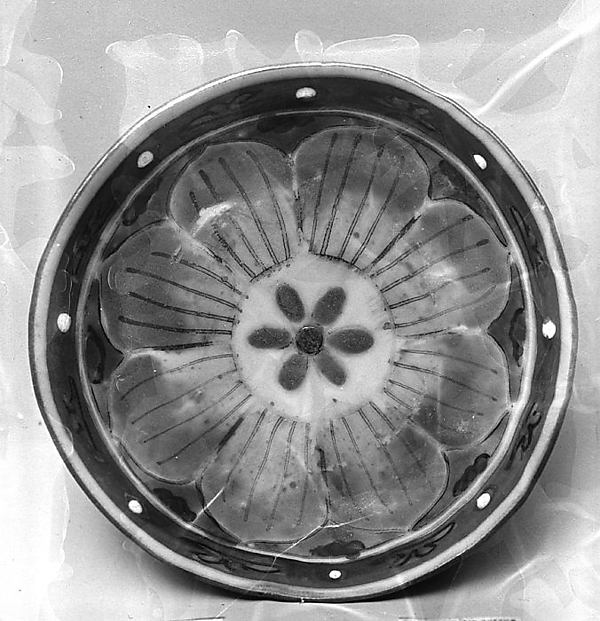

8055
Porcelain with famille verte enamels


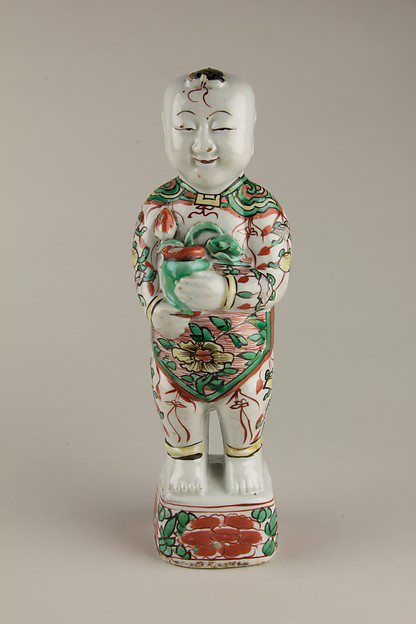

11201
Stoneware with iron-oxide glaze (Jian ware)


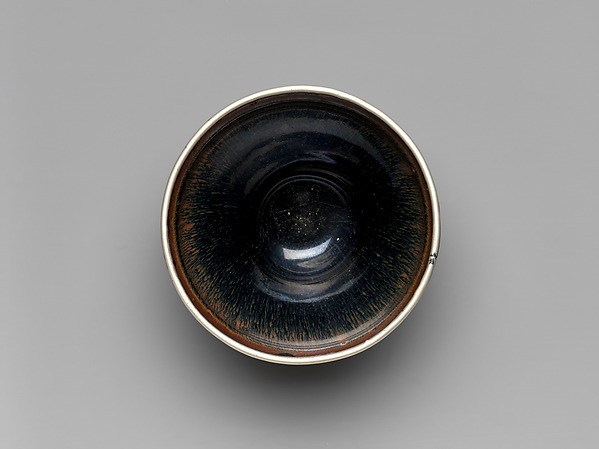

In [124]:
# Let's preview what some non-ivory art pieces look like, to compare
np.random.seed(45)
for index in np.random.choice(non_ivory_indexes_to_keep, size=3, replace=False):
    test = requests.get(merged_df.loc[index].Image_URL)
    img_test = Image.open(BytesIO(test.content))
    print(index)
    print(merged_df.loc[index].Medium)
    display(img_test)

### Concatenate new dataframes

In [125]:
final_df = pd.concat([new_ivory_df, new_non_ivory_df], ignore_index=True)
print(final_df.shape)
final_df.head()

(3540, 11)


Object_ID                                          Image_URL  \
0     248694  https://images.metmuseum.org/CRDImages/gr/web-...   
1     248695  https://images.metmuseum.org/CRDImages/gr/web-...   
2     257575  https://images.metmuseum.org/CRDImages/gr/web-...   
3      31064  https://images.metmuseum.org/CRDImages/aa/web-...   
4      34077  https://images.metmuseum.org/CRDImages/aa/web-...   

                 Title          Object_Name       Medium  \
0     Relief of a duck     Relief of a duck         Bone   
1    Relief of a child    Relief of a child         Bone   
2           Eye inlays           Eye inlays  Bone, ivory   
3  Sword with Scabbard  Sword with scabbard        Ivory   
4     Hilt of a Dagger     Hilt of a dagger        Ivory   

              Classification           Department                   Culture  \
0  Miscellaneous-Bone, Ivory  Greek and Roman Art                     Roman   
1  Miscellaneous-Bone, Ivory  Greek and Roman Art                       NaN   
2  Miscellaneous-Bone, Ivory  Greek and Roman Art                       NaN   
3                     Swords       Arms and Armor                     Batak   
4                    Daggers       Arms and Armor  possibly Italian, Venice   

           Period        Object_Date  Target  
0  Early Imperial   1st century A.D.       1  
1             NaN                NaN       1  
2             NaN                NaN       1  
3             NaN  16th–19th century       1  
4             NaN           ca. 1300       1

<br>

# Saving Images, File Management, and Train/Validation/Test Split

### Save images to data folder

In [126]:
ivory_indexes = final_df.loc[final_df['Target'] == 1].index
non_ivory_indexes = final_df.loc[final_df['Target'] == 0].index

# Sanity check
ivory_indexes.shape[0] + non_ivory_indexes.shape[0] == final_df.shape[0]

True

In [127]:
ivory_dir_len = len([name for name in os.listdir('data/images/ivory') if not name.endswith('checkpoints')])

# Index filled in from previous run of API call
unidentified_ivory_images = [924]

if ivory_dir_len == 0:
    for index in ivory_indexes:
        try:
            response = requests.get(final_df.Image_URL.loc[index])
            img = Image.open(BytesIO(response.content))
            img.save('data/images/ivory/ivory_' + str(merged_df.iloc[index]['Object_ID']) + '.jpg')
        except:
            unidentified_ivory_images.append(index)
        
unidentified_ivory_images

[924]

In [128]:
non_ivory_dir_len = len([name for name in os.listdir('data/images/non_ivory') if not name.endswith('checkpoints')])

# Indexes filled in from previous run of API call
unidentified_non_ivory_images = [1996, 2233, 2288]

if non_ivory_dir_len == 0:
    for index in non_ivory_indexes:
        try:
            response = requests.get(final_df.Image_URL.loc[index])
            img = Image.open(BytesIO(response.content))
            img.save('data/images/non_ivory/non_ivory_' + str(merged_df.iloc[index]['Object_ID']) + '.jpg')
        except:
            unidentified_non_ivory_images.append(index)
            
unidentified_non_ivory_images

[1996, 2233, 2288]

### Drop rows with invalid image URLs

In [129]:
final_df = final_df.drop(unidentified_ivory_images)
final_df = final_df.drop(unidentified_non_ivory_images)

# Reset indexes
final_df.index = range(len(final_df))

print(f"Total items in dataset: {final_df.shape[0]}")
final_df.Target.value_counts()

Total items in dataset: 3536


1    1769
0    1767
Name: Target, dtype: int64

### Save dataframe as .csv file

In [130]:
if os.path.isfile('data/final_df.csv') == False:
    final_df.to_csv('data/final_df.csv')
else:
    final_df = pd.read_csv('data/final_df.csv', index_col=0)

### Create train, validation, and test splits of ivory and non-ivory images

In [131]:
data_ivory_dir = 'data/images/ivory/'
data_non_ivory_dir = 'data/images/non_ivory/'
split_dir = 'data/split/'

test_ivory = 'data/split/test/ivory/'
test_non_ivory = 'data/split/test/non_ivory/'

validation_ivory = 'data/split/validation/ivory/'
validation_non_ivory = 'data/split/validation/non_ivory/'

train_ivory = 'data/split/train/ivory/'
train_non_ivory = 'data/split/train/non_ivory/'

In [132]:
imgs_ivory = [file for file in os.listdir(data_ivory_dir) if file.endswith('.jpg')]

# Randomize order
random.seed(42)
random.shuffle(imgs_ivory)

print('There are', len(imgs_ivory), 'ivory images')
imgs_ivory[:3]

There are 1769 ivory images


['ivory_170565.jpg', 'ivory_53818.jpg', 'ivory_209774.jpg']

In [133]:
imgs_non_ivory = [file for file in os.listdir(data_non_ivory_dir) if file.endswith('.jpg')]

# Randomize order
random.seed(42)
random.shuffle(imgs_non_ivory)

print('There are', len(imgs_non_ivory), 'non-ivory images')
imgs_non_ivory[:3]

There are 1767 non-ivory images


['non_ivory_42450.jpg', 'non_ivory_59994.jpg', 'non_ivory_450820.jpg']

In [134]:
# We'll do an 80/20 train/test split; of the training data, we'll do another 80/20 train/validation split

print(f"Ivory test images slice:        {int(1769*0.8)+1}:1769  --> {int(1769*0.2)} images")
print(f"Ivory validation images slice:  {int(1415*0.8)+1}:{int(1769*0.8)+1}  --> {int(1415*0.2)} images")
print(f"Ivory train images slice:       0:{int(1415*0.8)+1}     --> {int(1415*0.8)+1} images")

Ivory test images slice:        1416:1769  --> 353 images
Ivory validation images slice:  1133:1416  --> 283 images
Ivory train images slice:       0:1133     --> 1133 images


In [135]:
# Repeat for non-ivory images

print(f"Non-ivory test images slice:        {int(1767*0.8)+1}:1767  --> {int(1767*0.2)} images")
print(f"Non-ivory validation images slice:  {int(1414*0.8)+1}:{int(1767*0.8)+1}  --> {int(1414*0.2)} images")
print(f"Non-ivory train images slice:       0:{int(1414*0.8)+1}     --> {int(1414*0.8)+1} images")

Non-ivory test images slice:        1414:1767  --> 353 images
Non-ivory validation images slice:  1132:1414  --> 282 images
Non-ivory train images slice:       0:1132     --> 1132 images


In [136]:
# Test ivory images
imgs = imgs_ivory[1416:1769]
dir_length = len([name for name in os.listdir('data/split/test/ivory') if not name.endswith('checkpoints')])
if dir_length == 0:
    for img in imgs:
        origin = os.path.join(data_ivory_dir + img)
        destination = os.path.join(test_ivory + img)
        shutil.copyfile(origin, destination)
    
# Validation ivory images
imgs = imgs_ivory[1133:1416]
dir_length = len([name for name in os.listdir('data/split/validation/ivory') if not name.endswith('checkpoints')])
if dir_length == 0:
    for img in imgs:
        origin = os.path.join(data_ivory_dir + img)
        destination = os.path.join(validation_ivory + img)
        shutil.copyfile(origin, destination)
    
# Train ivory images
imgs = imgs_ivory[0:1133]
dir_length = len([name for name in os.listdir('data/split/train/ivory') if not name.endswith('checkpoints')])
if dir_length == 0:
    for img in imgs:
        origin = os.path.join(data_ivory_dir + img)
        destination = os.path.join(train_ivory + img)
        shutil.copyfile(origin, destination)
    
print('There are', len(os.listdir(test_ivory)), 'ivory images in the test set')
print('There are', len(os.listdir(validation_ivory)), 'ivory images in the validation set')
print('There are', len(os.listdir(train_ivory)), 'ivory images in the train set')

There are 353 ivory images in the test set
There are 283 ivory images in the validation set
There are 1133 ivory images in the train set


In [137]:
# Test non-ivory images
imgs = imgs_non_ivory[1414:1767]
dir_length = len([name for name in os.listdir('data/split/test/non_ivory') if not name.endswith('checkpoints')])
if dir_length == 0:
    for img in imgs:
        origin = os.path.join(data_non_ivory_dir + img)
        destination = os.path.join(test_non_ivory + img)
        shutil.copyfile(origin, destination)
    
# Validation non-ivory images
imgs = imgs_non_ivory[1132:1414]
dir_length = len([name for name in os.listdir('data/split/validation/non_ivory') if not name.endswith('checkpoints')])
if dir_length == 0:
    for img in imgs:
        origin = os.path.join(data_non_ivory_dir + img)
        destination = os.path.join(validation_non_ivory + img)
        shutil.copyfile(origin, destination)
    
# Train non-ivory images
imgs = imgs_non_ivory[0:1132]
dir_length = len([name for name in os.listdir('data/split/train/non_ivory') if not name.endswith('checkpoints')])
if dir_length == 0:
    for img in imgs:
        origin = os.path.join(data_non_ivory_dir + img)
        destination = os.path.join(train_non_ivory + img)
        shutil.copyfile(origin, destination)
    
print('There are', len(os.listdir(test_non_ivory)), 'non-ivory images in the test set')
print('There are', len(os.listdir(validation_non_ivory)), 'non-ivory images in the validation set')
print('There are', len(os.listdir(train_non_ivory)), 'non-ivory images in the train set')

There are 353 non-ivory images in the test set
There are 282 non-ivory images in the validation set
There are 1132 non-ivory images in the train set


### Examine image resolutions

In a moment we'll have to select the new target sizes (resolutions) for our images. Below we create a plot of the current resolutions of our images to help us decide.

In [138]:
# Get image resolutions
ivory_imgs_sizes = [img.name for img in Path('data/images/ivory/').iterdir() if img.suffix == ".jpg"]
non_ivory_imgs_sizes = [img.name for img in Path('data/images/non_ivory/').iterdir() if img.suffix == ".jpg"]
img_meta = {}
for f in ivory_imgs_sizes: img_meta[str(f)] = imagesize.get('data/images/ivory/'+f)
for f in non_ivory_imgs_sizes: img_meta[str(f)] = imagesize.get('data/images/non_ivory/'+f)

# Convert it to Dataframe and compute aspect ratio
img_meta_df = pd.DataFrame.from_dict([img_meta]).T.reset_index().set_axis(['FileName', 'Size'], axis='columns')
img_meta_df[["Width", "Height"]] = pd.DataFrame(img_meta_df["Size"].tolist(), index=img_meta_df.index)
img_meta_df["Aspect Ratio"] = round(img_meta_df["Width"] / img_meta_df["Height"], 2)

print(f'Total number of images in dataset: {len(img_meta_df)}')
img_meta_df.head()

Total number of images in dataset: 3536


FileName        Size  Width  Height  Aspect Ratio
0   ivory_10074.jpg  (327, 624)    327     624          0.52
1   ivory_10088.jpg  (331, 624)    331     624          0.53
2  ivory_101171.jpg  (599, 562)    599     562          1.07
3   ivory_10135.jpg  (400, 625)    400     625          0.64
4   ivory_10137.jpg  (600, 558)    600     558          1.08

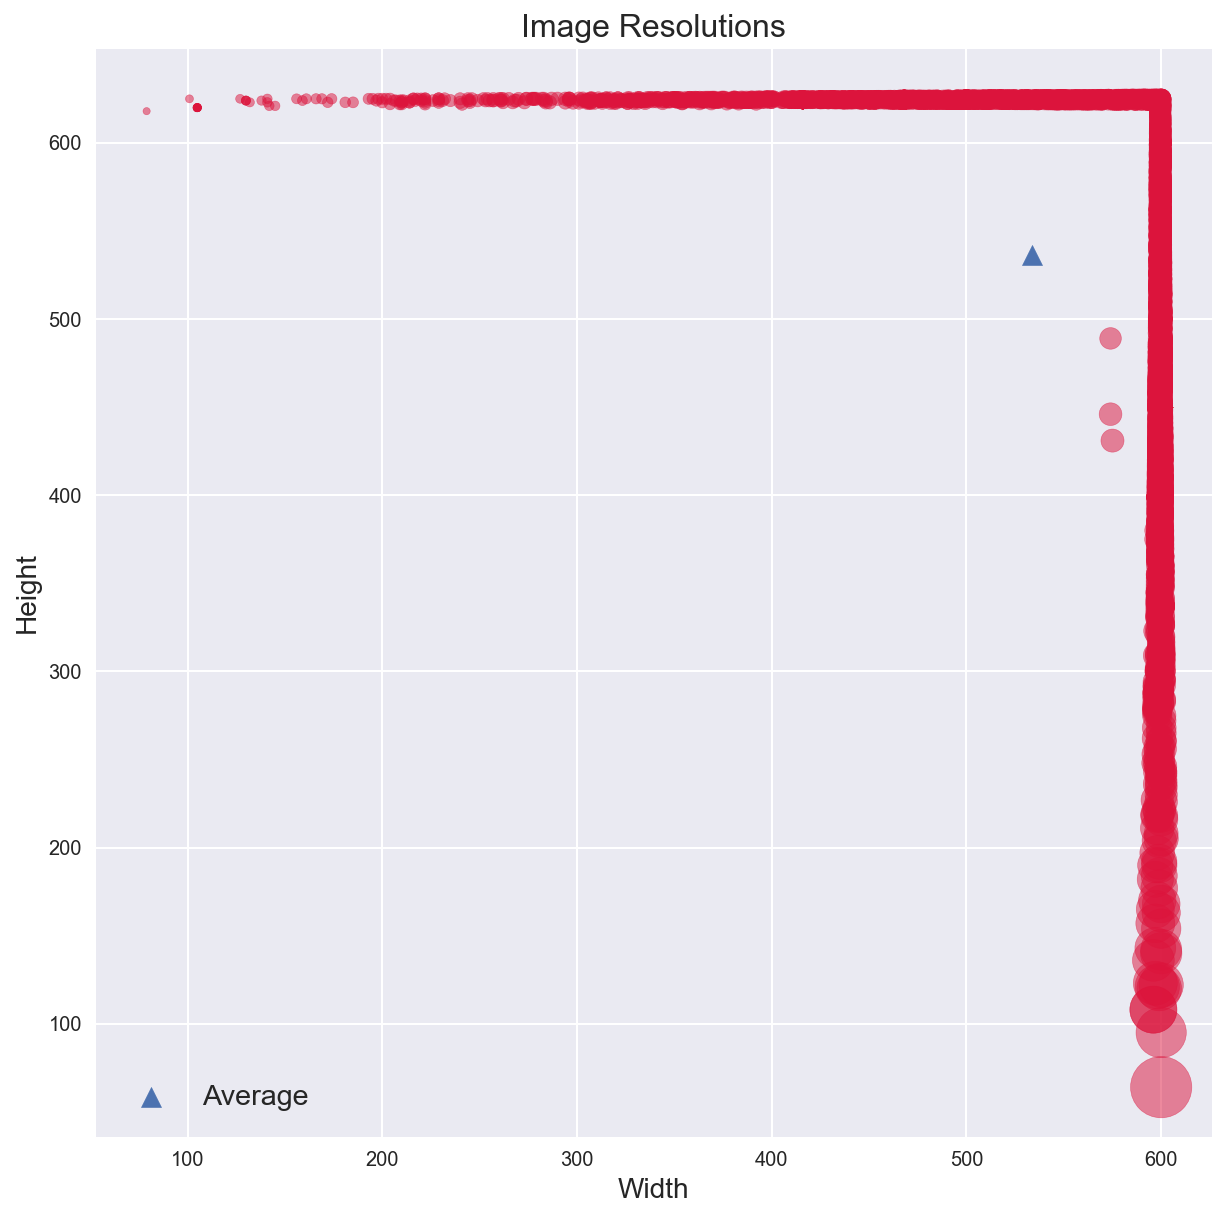

In [140]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(img_meta_df.Width, img_meta_df.Height, color='crimson', alpha=0.5, s=img_meta_df['Aspect Ratio']*100)
ax.set_title('Image Resolutions', size=16)
ax.set_xlabel('Width', size=14)
ax.set_ylabel('Height', size=14)
ax.set_xticks(list(range(0, 800, 100)))
ax.set_yticks(list(range(0, 800, 100)))
ax.scatter(x=img_meta_df.Width.mean(), y=img_meta_df.Height.mean(), marker='^', s=100, label='Average')
ax.legend(loc=3, fontsize='x-large');

**Remarks:**
- It looks like all images have either a width or height of around 600, and the average image is around 520x520. A conservative reshaping, without having to upsample too many images, would be 256x256.

### Create ImageDataGenerators for test, validation, and training images

In [141]:
test_folder = os.path.join(split_dir, 'test')
validation_folder = os.path.join(split_dir, 'validation')
train_folder = os.path.join(split_dir, 'train')


# Get all the data in the directory data/split/test (706 images), and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_folder, 
                                                                        classes=['non_ivory', 'ivory'], 
                                                                        target_size=(256, 256), batch_size=706) 

# Get all the data in the directory data/split/validation (565 images), and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_folder, 
                                                                       classes=['non_ivory', 'ivory'], 
                                                                       target_size=(256, 256), batch_size=565)

# Get all the data in the directory data/split/train (2265 images), and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(train_folder, 
                                                                         classes=['non_ivory', 'ivory'], 
                                                                         target_size=(256, 256), batch_size=2265)

train_generator.class_indices

Found 706 images belonging to 2 classes.
Found 565 images belonging to 2 classes.
Found 2265 images belonging to 2 classes.


{'non_ivory': 0, 'ivory': 1}

In [142]:
# Create the data sets
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)
train_images, train_labels = next(train_generator)

In [143]:
# Explore the dataset again
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print('-'*40)
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print('-'*40)
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))
print('-'*40)
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))

Number of training samples: 2265
Number of testing samples: 706
Number of validation samples: 565
----------------------------------------
test_images shape: (706, 256, 256, 3)
test_labels shape: (706, 2)
----------------------------------------
val_images shape: (565, 256, 256, 3)
val_labels shape: (565, 2)
----------------------------------------
train_images shape: (2265, 256, 256, 3)
train_labels shape: (2265, 2)


In [144]:
# Reshape test, validation, and train images for baseline fully connected (dense) neural network model
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)
train_img = train_images.reshape(train_images.shape[0], -1)

test_y = np.reshape(test_labels[:,0], (test_img.shape[0],1))
val_y = np.reshape(val_labels[:,0], (val_img.shape[0],1))
train_y = np.reshape(train_labels[:,0], (train_img.shape[0],1))

print("test_img shape: ", str(test_img.shape))
print("val_img shape: ", str(val_img.shape))
print("train_img shape: ", str(train_img.shape))
print('-'*40)
print("test_y shape: ", str(test_y.shape))
print("val_y shape: ", str(val_y.shape))
print("train_y shape: ", str(train_y.shape))

test_img shape:  (706, 196608)
val_img shape:  (565, 196608)
train_img shape:  (2265, 196608)
----------------------------------------
test_y shape:  (706, 1)
val_y shape:  (565, 1)
train_y shape:  (2265, 1)


<br>

# Helper Functions

### Function to plot selection of images and corresponding class labels

In [145]:
def plot_images(images, figsize=(20,4), rows=1, interp=False, titles=None):
    """
    Takes in image set and image labels and plots a row of the 
    images with associated labels.
    """
    if type(images[0]) is np.ndarray:
        images - np.array(images).astype(np.uint8)
        if (images.shape[-1] != 3):
            images - images.transpose((0,2,3,1))
    fig = plt.figure(figsize=figsize)
    cols = len(images)//rows if len(images) % 2 -- 0 else len(images)//rows + 1
    for i in range(len(images)):
        sp = fig.add_subplot(rows, cols, i +1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=15)
        plt.imshow(images[i], interpolation=None if interp else 'none')

C:\Users\harri\anaconda3\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


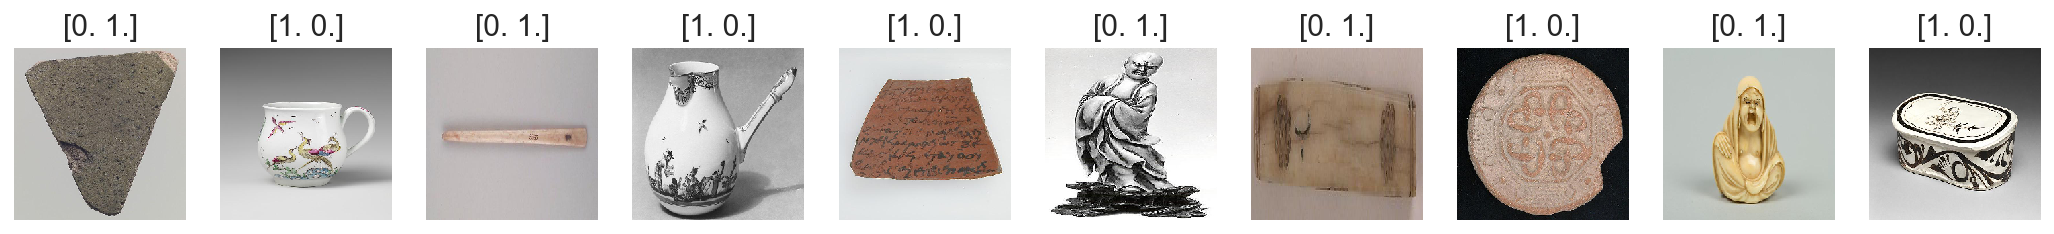

In [146]:
# View first 10 items from train_images
plot_images(train_images[0:10], titles=train_labels[0:10])

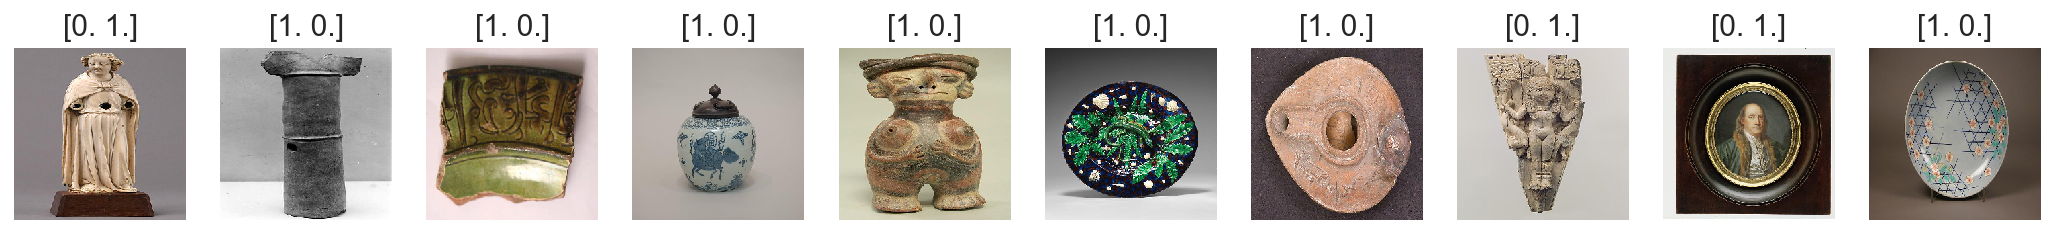

In [147]:
# View first 10 items from test_images
plot_images(test_images[0:10], titles=test_labels[0:10])

### Function to display and plot model accuracy and loss scores

In [148]:
def get_model_results(model, model_history):
    """ 
    Takes in a model and model history, and returns the model's 
    loss and accuracy scores. Also returns plots of the training 
    and validation scores across all epochs for accuracy and loss.
    """
    # Return loss and accuracy scores for training and test sets
    if model == baseline_model:
        results_train = model.evaluate(train_img, train_y)
        results_test = model.evaluate(test_img, test_y)
    else:
        results_train = model.evaluate(train_images, train_y)
        results_test = model.evaluate(test_images, test_y)
    
    # Get accuracy and loss for training and validation
    if model == baseline_model:
        acc = model_history.history['accuracy']
        val_acc = model_history.history['val_accuracy']
        loss = model_history.history['loss']
        val_loss = model_history.history['val_loss']
    else:
        acc = model_history.history['acc']
        val_acc = model_history.history['val_acc']
        loss = model_history.history['loss']
        val_loss = model_history.history['val_loss']
    epochs = range(len(acc))
    
    # Return train and test loss and accuracy
    print("-"*40)
    print("Training set loss:", round(results_train[0], 3))
    print("Training set accuracy:", round(results_train[1], 3))
    print("-"*40)
    print("Test set loss:", round(results_test[0], 3))
    print("Test set accuracy:", round(results_test[1], 3))
    
    # Plot the training and validation accuracy and loss
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))
    ax1.plot(epochs, acc, label='Training acc')
    ax1.plot(epochs, val_acc, label='Validation acc')
    ax1.set_title('Training and Validation Accuracy', size=12, fontweight='bold')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Score')
    ax1.legend()
    ax2.plot(epochs, loss, label='Training loss')
    ax2.plot(epochs, val_loss, label='Validation loss')
    ax2.set_title('Training and Validation Loss', size=12, fontweight='bold')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Score')
    ax2.legend()

### Function to plot confusion matrix and ROC-AUC curve

In [149]:
def plot_model_results(model):
    if model == baseline_model:
        y_proba = model.predict(test_img)
    else:
        y_proba = model.predict(test_images)
        
    predicted = y_proba.round()
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))

    # Plot confusion matrix
    cm = confusion_matrix(test_y, predicted)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0: Non-ivory', '1: Ivory'])
    disp.plot(cmap='Reds', ax=ax1)
    ax1.set_title('Confusion Matrix', size=14, fontweight='bold')
    ax1.grid(False)
    
    # Plot ROC-AUC curve
    fpr, tpr, thresholds = metrics.roc_curve(test_y, predicted)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='ROC-AUC Curve')
    display.plot(c='crimson', ax=ax2)
    ax2.set_title('ROC-AUC Plot', size=14, fontweight='bold')
    ax2.plot([0, 1], [0, 1], c='black', linestyle='dotted')
    plt.show();

<br>

# Model 0: Baseline Model

In [150]:
# Build a baseline fully connected model
np.random.seed(7)
baseline_model = models.Sequential()
baseline_model.add(layers.Dense(20, activation='relu', input_shape=(train_img.shape[1],)))
baseline_model.add(layers.Dense(7, activation='relu'))
baseline_model.add(layers.Dense(5, activation='relu'))
baseline_model.add(layers.Dense(1, activation='sigmoid'))

baseline_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 20)                3932180   
                                                                 
 dense_9 (Dense)             (None, 7)                 147       
                                                                 
 dense_10 (Dense)            (None, 5)                 40        
                                                                 
 dense_11 (Dense)            (None, 1)                 6         
                                                                 
Total params: 3,932,373
Trainable params: 3,932,373
Non-trainable params: 0
_________________________________________________________________


In [151]:
baseline_model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.001,momentum=0.0,nesterov=False,name='SGD'), 
                       loss='binary_crossentropy', 
                       metrics=['accuracy']
                       )

# Terminate training if no improvement on specified min_delta for 5 epochs
train_callback = EarlyStopping(monitor='loss', min_delta=1e-4, patience=5)

if os.path.isfile('data/models/baseline_model_history.pkl') == False:
    baseline_model_history = baseline_model.fit(train_img, 
                                                train_y, 
                                                epochs=30, 
                                                batch_size=32, 
                                                validation_data=(val_img, val_y), 
                                                callbacks=[train_callback])

In [152]:
# # Save model and history as pickle objects, or open saved objects if model/history have already been saved
# if os.path.isfile('data/models/baseline_model.pkl') == False:
#     with open('data/models/baseline_model.pkl', 'wb') as f:
#         joblib.dump(baseline_model, f)
# if os.path.isfile('data/models/baseline_model_history.pkl') == False:
#     with open('data/models/baseline_model_history.pkl', 'wb') as f:
#         joblib.dump(baseline_model_history, f)
# if os.path.isfile('data/models/baseline_model.pkl') == True:
#     with open('data/models/baseline_model.pkl', 'rb') as f:
#         baseline_model = joblib.load(f)
# if os.path.isfile('data/models/baseline_model_history.pkl') == True:
#     with open('data/models/baseline_model_history.pkl', 'rb') as f:
#         baseline_model_history = joblib.load(f)

In [153]:
get_model_results(baseline_model, baseline_model_history)

NameError: name 'baseline_model_history' is not defined

23/23 [==============================] - 0s 5ms/step


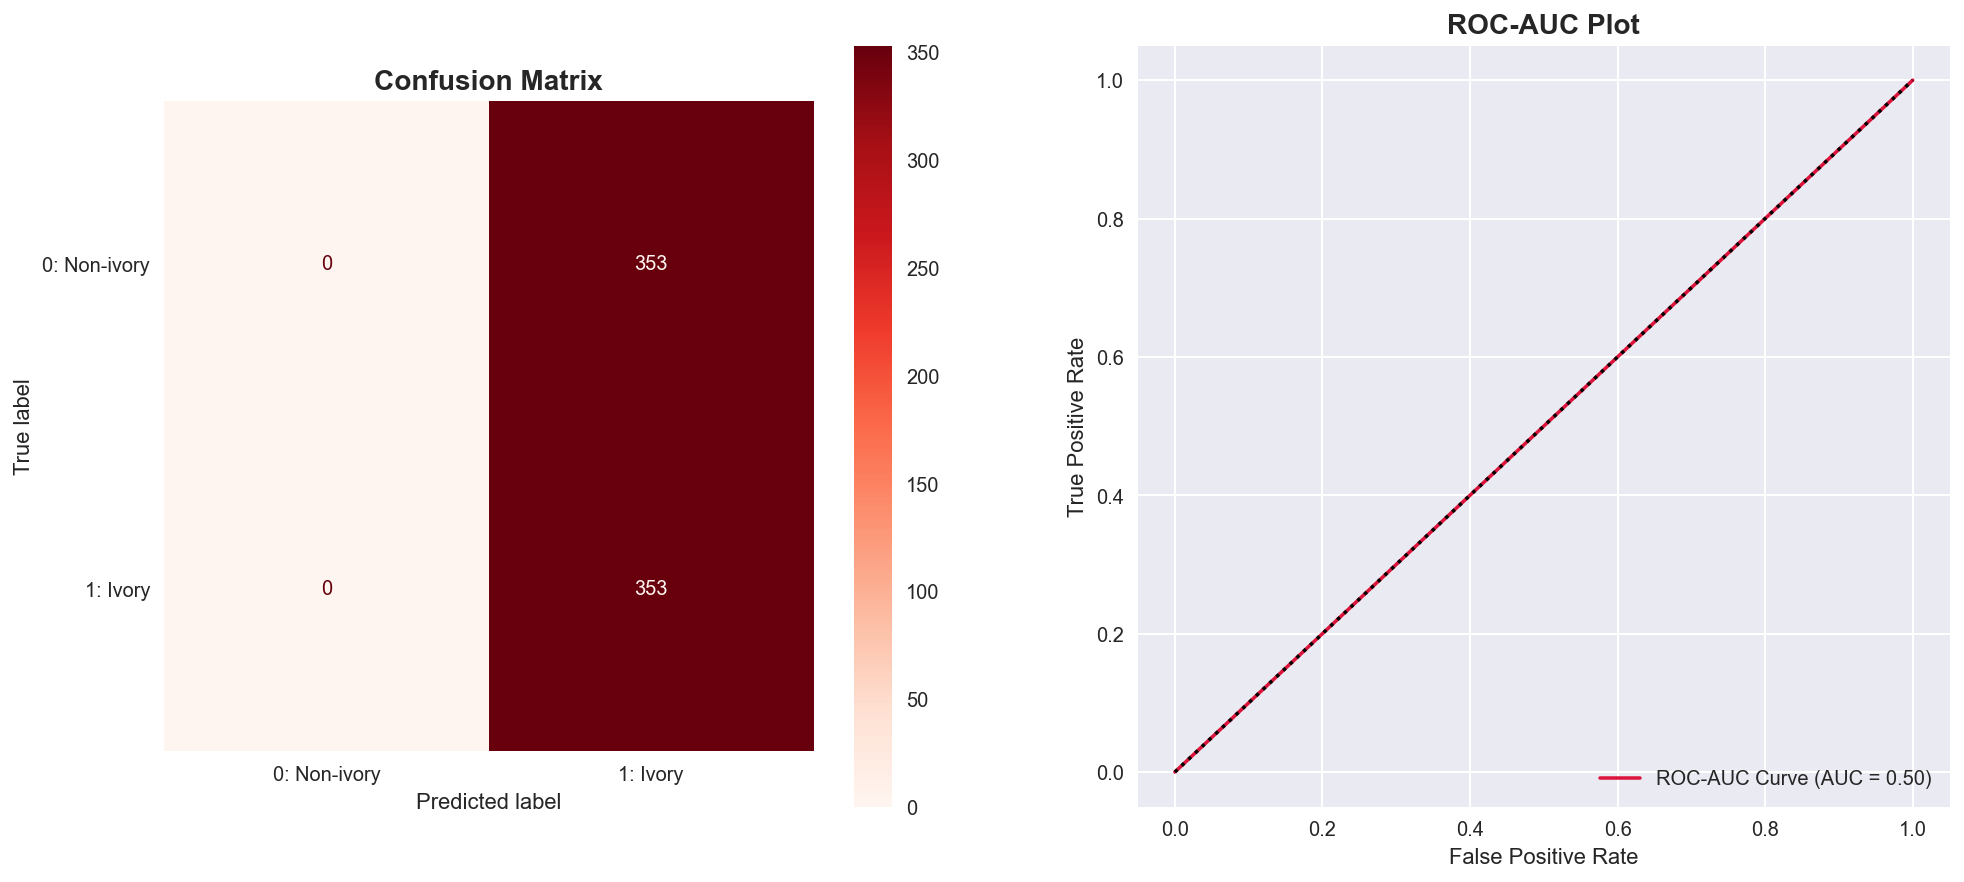

In [154]:
plot_model_results(baseline_model)

In [155]:
baseline_model.save('')

INFO:tensorflow:Assets written to: assets


INFO:tensorflow:Assets written to: assets


**Remarks:**
 - Remarks here

<br>

# Model 1: CNN, Iteration 1

In [156]:
np.random.seed(7)
model_1 = models.Sequential()
model_1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model_1.add(layers.MaxPooling2D((2, 2)))

model_1.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))

model_1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))

model_1.add(layers.Flatten())
model_1.add(layers.Dense(64, activation='relu'))
model_1.add(layers.Dense(1, activation='sigmoid'))

model_1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 124, 124, 32)      16416     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 30, 30, 64)      

In [157]:
import time

In [160]:
model_1.compile(optimizer=keras.optimizers.SGD(learning_rate=0.005,momentum=0.0,nesterov=False,name='SGD'), 
                       loss='binary_crossentropy', 
                       metrics=['accuracy']
                       ), 

#if os.path.isfile('data/models/model_1_history.pkl') == False:
model_1_history = model_1.fit(train_images, 
                              train_y, 
                              epochs=50, 
                              batch_size=32, 
                              validation_data=(val_images, val_y), 
                              callbacks=[train_callback])

Epoch 1/50
71/71 [==============================] - 53s 742ms/step - loss: 0.6205 - accuracy: 0.6587 - val_loss: 0.6032 - val_accuracy: 0.6973
Epoch 2/50
71/71 [==============================] - 52s 736ms/step - loss: 0.5943 - accuracy: 0.6865 - val_loss: 0.5616 - val_accuracy: 0.7522
Epoch 3/50
71/71 [==============================] - 52s 737ms/step - loss: 0.5797 - accuracy: 0.7007 - val_loss: 0.5936 - val_accuracy: 0.6602
Epoch 4/50
71/71 [==============================] - 53s 742ms/step - loss: 0.5635 - accuracy: 0.7152 - val_loss: 0.5584 - val_accuracy: 0.7044
Epoch 5/50
71/71 [==============================] - 54s 768ms/step - loss: 0.5540 - accuracy: 0.7280 - val_loss: 0.5051 - val_accuracy: 0.7752
Epoch 6/50
71/71 [==============================] - 54s 768ms/step - loss: 0.5399 - accuracy: 0.7355 - val_loss: 0.5011 - val_accuracy: 0.7770
Epoch 7/50
71/71 [==============================] - 56s 790ms/step - loss: 0.5289 - accuracy: 0.7426 - val_loss: 0.4912 - val_accuracy: 0.7735

KeyboardInterrupt: 

In [55]:
# Save model and history as pickle objects, or open saved objects if model/history have already been saved
if os.path.isfile('data/models/model_1.pkl') == False:
    with open('data/models/model_1.pkl', 'wb') as f:
        joblib.dump(model_1, f)
if os.path.isfile('data/models/model_1_history.pkl') == False:
    with open('data/models/model_1_history.pkl', 'wb') as f:
        joblib.dump(model_1_history, f)        
if os.path.isfile('data/models/model_1.pkl') == True:
    with open('data/models/model_1.pkl', 'rb') as f:
        model_1 = joblib.load(f)
if os.path.isfile('data/models/model_1_history.pkl') == True:
    with open('data/models/model_1_history.pkl', 'rb') as f:
        model_1_history = joblib.load(f)

FileNotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ram://c127c2cb-44c5-45bd-9dea-09a14e18dd28/variables/variables
 You may be trying to load on a different device from the computational device. Consider setting the `experimental_io_device` option in `tf.saved_model.LoadOptions` to the io_device such as '/job:localhost'.

In [75]:
model_1.save('data\models\model_res_600')

INFO:tensorflow:Assets written to: data\models\model_res_600\assets


INFO:tensorflow:Assets written to: data\models\model_res_600\assets


In [71]:
import pickle

In [90]:
# with open('data\models\model_res_600_history.pkl', 'wb') as file_pi:
#     pickle.dump(model_1_history.history, file_pi)

In [93]:
# with open("data\models\model_res_600_history.pkl", "rb") as input_file:
#      e = pickle.load(input_file)
# e

{'loss': [0.6885077953338623,
  0.6709794402122498,
  0.6467055678367615,
  0.6297115087509155,
  0.6080687642097473,
  0.5864385962486267,
  0.5722091197967529,
  0.5430346131324768,
  0.5274376273155212,
  0.5128636956214905,
  0.49290403723716736,
  0.47327926754951477,
  0.4638015925884247,
  0.44050344824790955,
  0.4217684268951416,
  0.40361839532852173,
  0.45200952887535095,
  0.382522314786911,
  0.3610066771507263,
  0.340930312871933,
  0.32132688164711,
  0.31987833976745605,
  0.2954864799976349,
  0.348257452249527,
  0.2581292986869812,
  0.25920864939689636,
  0.27548345923423767,
  0.1772202104330063,
  0.17423559725284576,
  0.13028091192245483],
 'acc': [0.5474613904953003,
  0.5942605137825012,
  0.6309050917625427,
  0.6596026420593262,
  0.6883001923561096,
  0.6966887712478638,
  0.7134658098220825,
  0.7320088148117065,
  0.7395143508911133,
  0.7558498978614807,
  0.7642384171485901,
  0.7858719825744629,
  0.7885209918022156,
  0.8057395219802856,
  0.8150110

In [95]:
# from tensorflow import keras
# model_hi = keras.models.load_model('data\models\model_res_600')

In [96]:
get_model_results(model_hi, e)

23/23 [==============================] - 19s 668ms/step - loss: 0.4834 - acc: 0.8244


AttributeError: 'dict' object has no attribute 'history'

23/23 [==============================] - 20s 676ms/step - loss: 0.4834 - acc: 0.8244
----------------------------------------
Training set loss: 0.103
Training set accuracy: 0.973
----------------------------------------
Test set loss: 0.483
Test set accuracy: 0.824


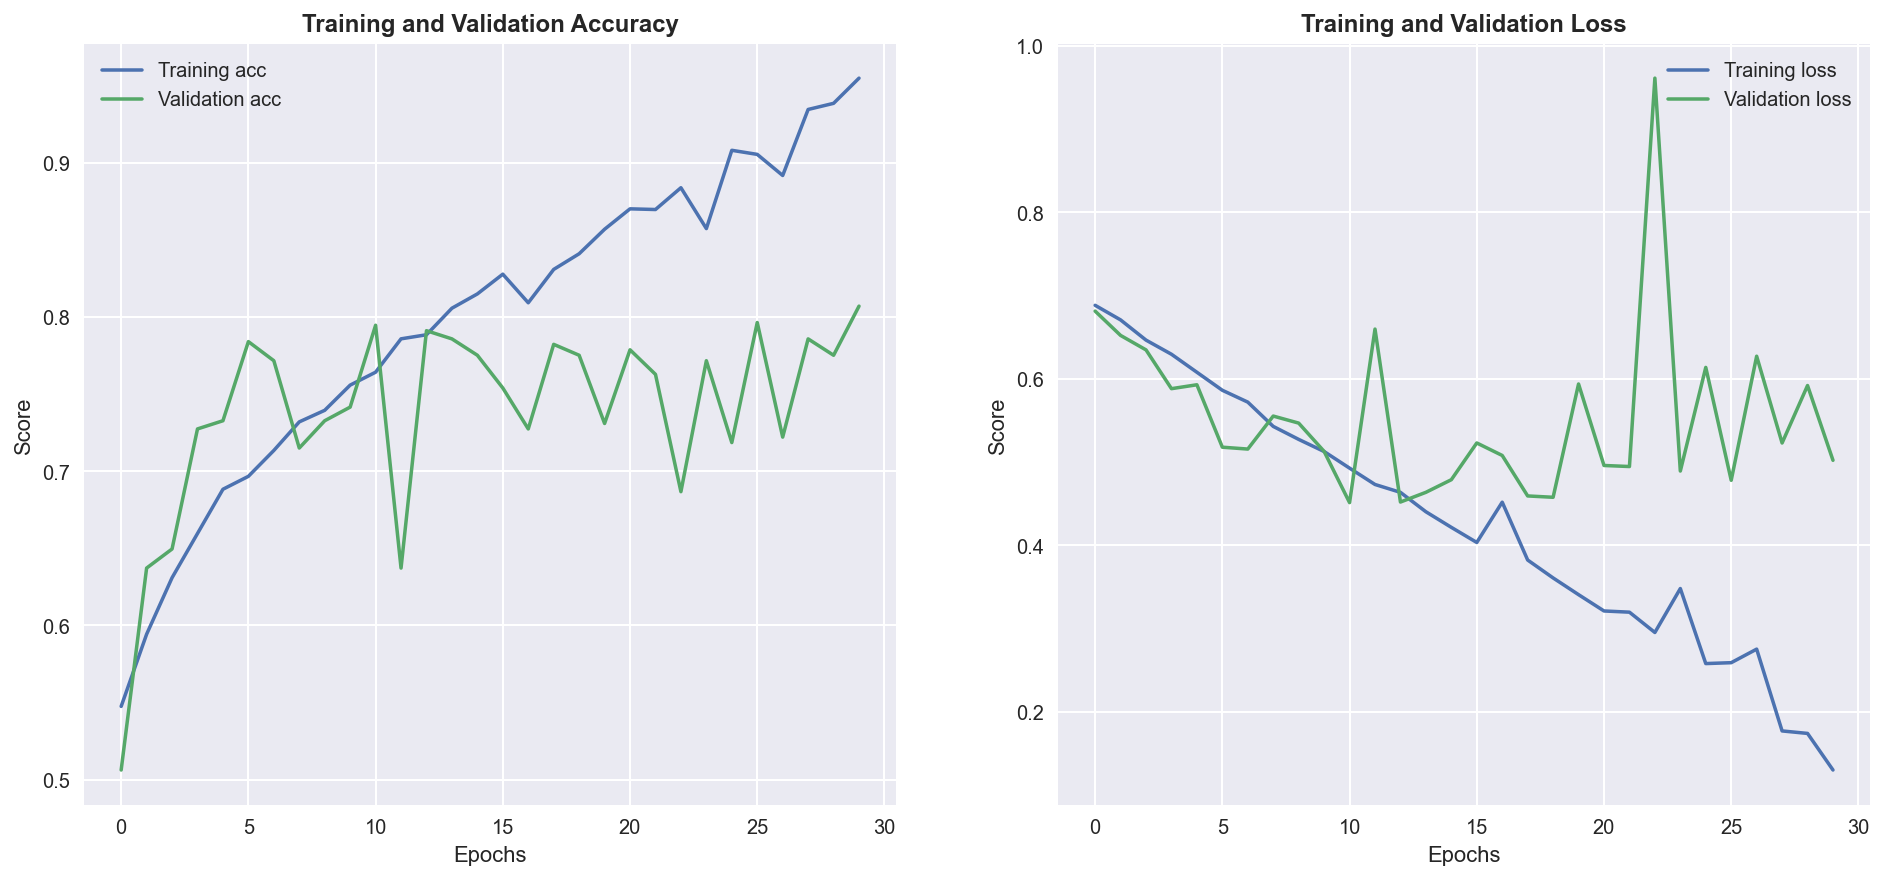

In [68]:
get_model_results(model_1, model_1_history)

23/23 [==============================] - 15s 635ms/step


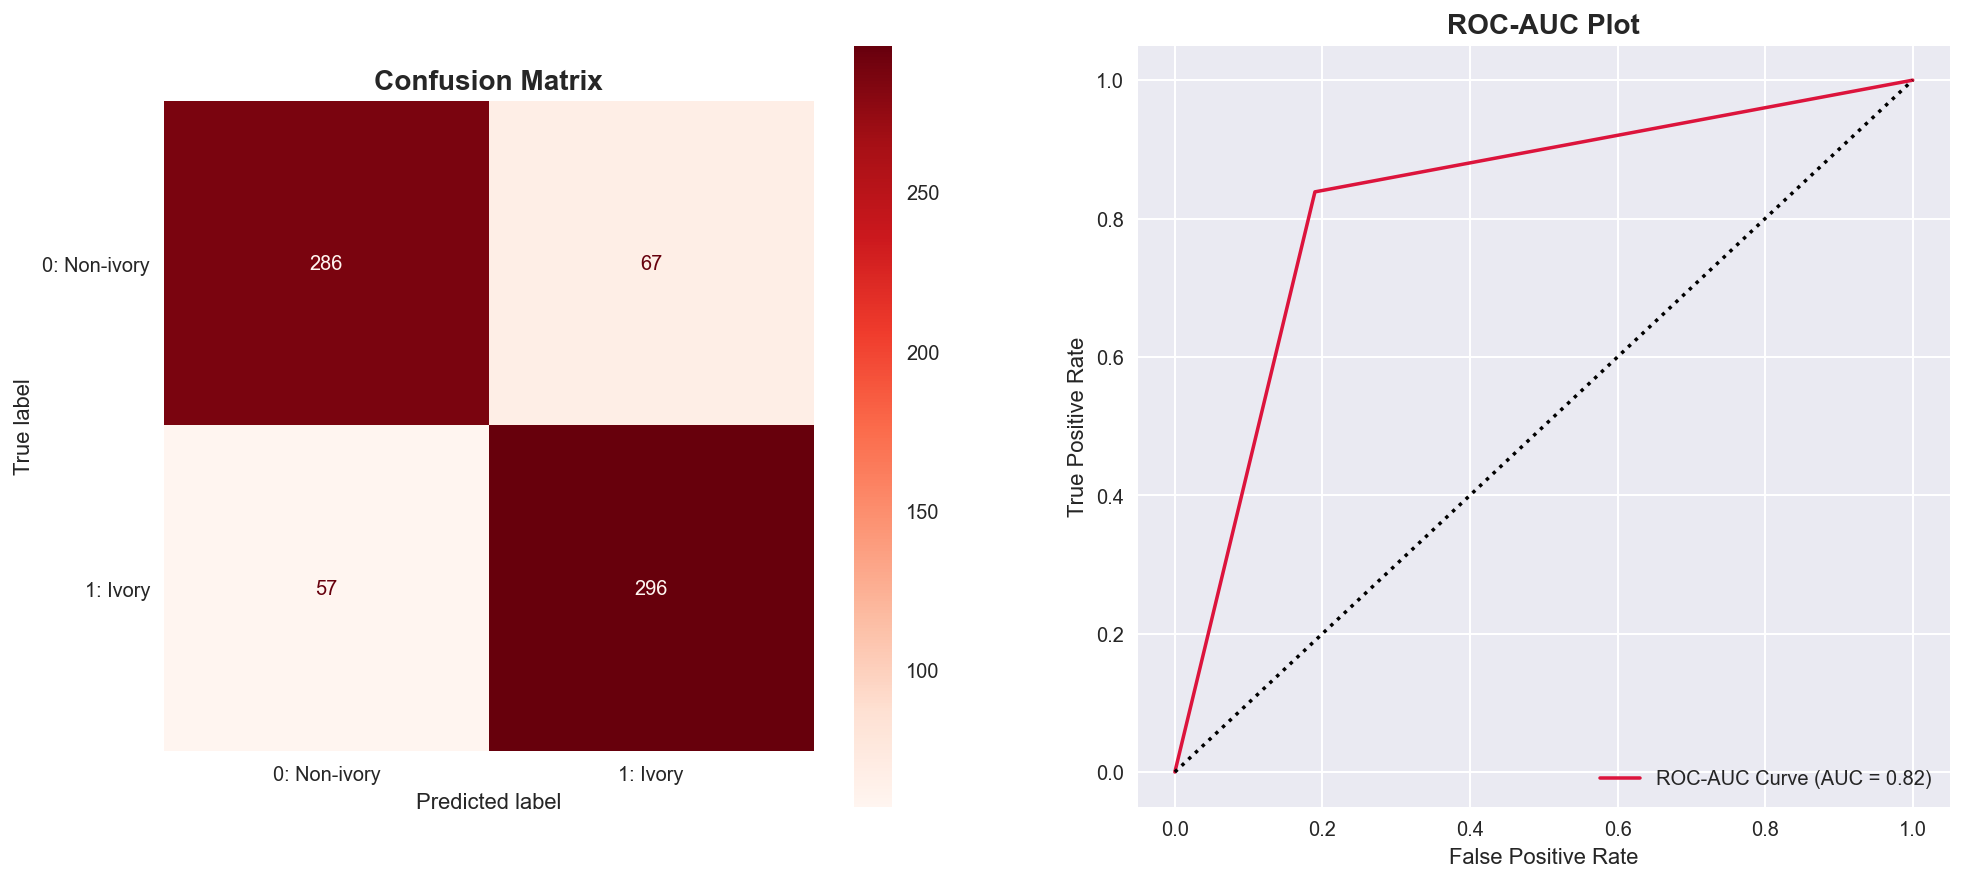

In [69]:
plot_model_results(model_1)

**Remarks:**
- Remarks here

<br>